### Imports

In [1]:
from sklearn.model_selection import train_test_split
from random import shuffle
import skimage.transform as transform
import csv
import cv2
import numpy as np
import sklearn
import math
import pandas as pd
import sklearn.utils
import os
import glob

# Keras
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Flatten, Lambda,  Dropout,Cropping2D, Convolution2D,Input
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.initializations import  normal
from data import *

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('./data/driving_log.csv')
data = sklearn.utils.shuffle(data)
data.mean()

# Split traning data
train_samples, validation_samples = train_test_split(data, test_size=0.2)

### Load data


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9aa86239b0>]], dtype=object)

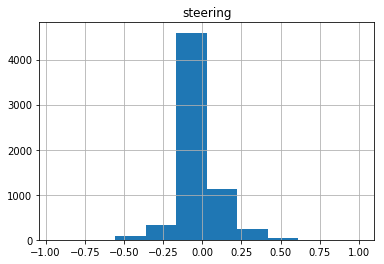

In [3]:
train_samples.hist(column='steering')

In [4]:
print(train_samples[train_samples.steering != 0].shape)
print(train_samples[train_samples.steering  > 0.1].shape)
print(train_samples[train_samples.steering  < -0.1].shape)

(2964, 7)
(962, 7)
(756, 7)


In [5]:
df = pd.read_csv('data/driving_log.csv')

balanced = pd.DataFrame()   # Balanced dataset
bins = 1000                 # N of bins
bin_n = 200                 # N of examples to include in each bin (at most)

start = 0
for end in np.linspace(0, 1, num=bins):  
    df_range = df[(np.absolute(df.steering) >= start) & (np.absolute(df.steering) < end)]
    range_n = min(bin_n, df_range.shape[0])
    if range_n == 0:
        continue
    balanced = pd.concat([balanced, df_range.sample(range_n)])
    start = end
balanced.to_csv('data/driving_log_balanced.csv', index=False)

(array([   5,    6,   40,  225,  661, 1478, 1072,  289,   48,   12]),
 array([-0.9426954 , -0.77527015, -0.6078449 , -0.44041965, -0.2729944 ,
        -0.10556915,  0.0618561 ,  0.22928135,  0.3967066 ,  0.56413185,
         0.7315571 ]))

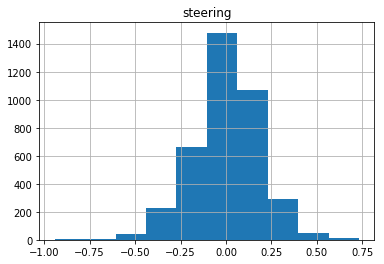

In [6]:
df = pd.read_csv('data/driving_log_balanced.csv')
df.hist(column='steering')

x = df.as_matrix(columns=['steering'])
np.histogram(x)

(160, 320, 3)


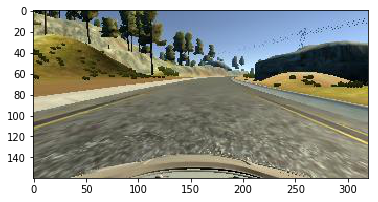

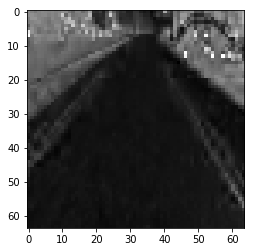

In [7]:
filename = "./data/IMG/"+ data.iloc[0]['center'].split("/")[-1]
image    = plt.imread(filename)
print(image.shape)
plt.imshow(image)
image = preprocess(image)
plt.figure()
plt.imshow(image[:,:,0], cmap='gray')


(160, 320, 3, 1)


(array([ 55335.,  40599.,  12375.,   7878.,  10814.,  13941.,   9001.,
          1001.,    466.,   2190.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

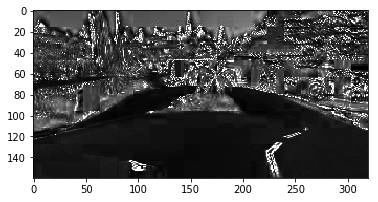

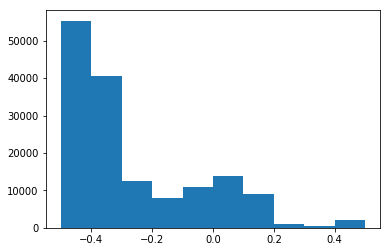

In [8]:
from numpy import newaxis

img = plt.imread('./data1/IMG/right_2017_08_14_19_13_58_132.jpg')
img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
img = img / 255  - .5

plt.imshow(img[:,:,2], cmap='gray')

img = img[..., newaxis]
print(img.shape)

x = img.reshape(153600,1)
plt.figure()
plt.hist(x)

### Data augmentation

(160, 320, 3)
(160, 320, 3)
(160, 320, 3)
(160, 320, 3)
(160, 320, 3)


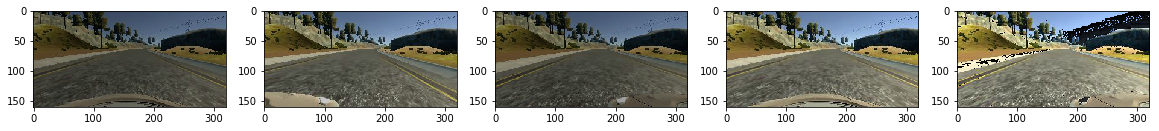

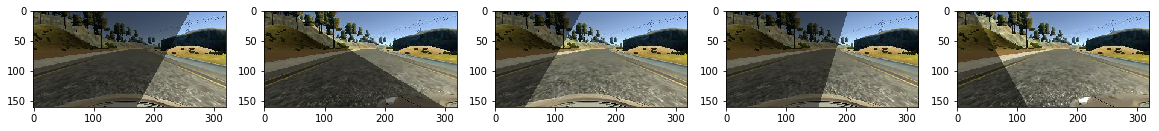

In [9]:
import random

def random_brightness(image):
    # Randomly select a percent change
    change_pct = random.uniform(0.4, 1.2)
    
    # Change to HSV to change the brightness V
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * change_pct
    
    #Convert back to RGB 
    img_brightness = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img_brightness

def random_shadow(image):
    h, w = image.shape[0], image.shape[1]
    [x1, x2] = np.random.choice(w, 2, replace=False)
    k = h / (x2 - x1)
    b = - k * x1
    for i in range(h):
        c = int((i - b) / k)
        image[i, :c, :] = (image[i, :c, :] * .5).astype(np.int32)
    return image

def trans_image(image, steer):
    trans_range = 100
    tr_x = trans_range * np.random.uniform() - trans_range / 2
    steer_ang = steer + tr_x / trans_range * 2 * .2
    tr_y = 0
    M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    image_tr = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return image_tr, steer_ang

size = 5
plt.figure(figsize=(20,20))
for i in range(size):
    image, angle = random_camera(data,0)
    plt.subplot(1,size,i+1)
    plt.imshow(random_brightness(image))
    
plt.figure(figsize=(20,20))
for i in range(size):
    image, angle = random_camera(data,0)
    print(image.shape)
    plt.subplot(1,size, i+1)
    plt.imshow(random_shadow(image))

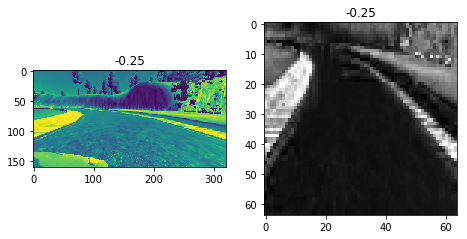

In [10]:
plt.figure(figsize=(20,20))
for i in range(1):
    image, angle = random_camera(data,5)
    plt.subplot(1,size, i+1)
    plt.title(str(angle))
    plt.imshow(image[:,:,0])
    
    image = preprocess(image)
    plt.subplot(1,size, i+2)
    plt.title(str(angle))
    plt.imshow(image[:,:,0], cmap='gray')

### Generator

Create generator to preprocess data

#### Create traning and validation


### Build model

In [11]:
learning_rate = 0.0001 # (good result)

opt = Adam(lr=learning_rate)

def small_model(learning_rate=0.0001):
    model = Sequential()
    model.add(Convolution2D(16, 3,3, subsample=(1, 1), activation="relu", input_shape=(64, 64, 1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D(32, 3,3, subsample=(1, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Convolution2D(64, 3,3, subsample=(1, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(512,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation="relu"))
    #model.add(Dropout(0.5))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(1))
    return model

model = small_model()
model.compile(loss="mse", optimizer=opt)
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 62, 62, 16)    160         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 31, 31, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 29, 29, 32)    4640        maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 14, 14, 32)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

### Train

In [12]:
def samples_count(total_count, batch_size):
    return math.ceil(total_count/batch_size) * batch_size

batch_size  = 32
epochs      = 3

train_generator      = generator(train_samples, batch_size=batch_size, trace=True)
validation_generator = generator(validation_samples, batch_size=batch_size, augmentation=False)

samples_per_epoch  = samples_count(45000, batch_size) #math.ceil((len(train_samples)*8)/batch_size) * batch_size
nb_val_samples     = samples_count(24000, batch_size) #math.ceil((len(validation_samples)*8) / batch_size) * batch_size

history = model.fit_generator(
    train_generator, 
    samples_per_epoch=samples_per_epoch, 
    validation_data=validation_generator,
    nb_val_samples=nb_val_samples, 
    nb_epoch=epochs,
    verbose=1).history

Epoch 1/3
45024/45024 [==============================] - 314s - loss: 0.0360 - val_loss: 0.0288
Epoch 2/3
45024/45024 [==============================] - 311s - loss: 0.0290 - val_loss: 0.0272
Epoch 3/3
45024/45024 [==============================] - 310s - loss: 0.0267 - val_loss: 0.0266


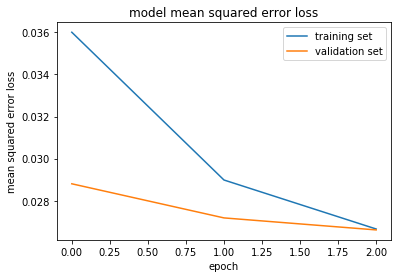

In [13]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save("model.h5")


In [14]:
X,y = next(validation_generator)
            
prediction = model.predict(X)  

array([-0.25      ,  0.25      ,  0.0222676 , -0.25      ,  0.08089697,
        0.25      ,  0.22822024,  0.        , -0.25      ,  0.        ,
        0.22822024, -0.25      , -0.25      ,  0.03305431, -0.0281274 ,
        0.4265823 ,  0.1047936 ,  0.25      ,  0.        ,  0.0904655 ,
        0.25      ,  0.25      ,  0.25      ,  0.        ,  0.25      ,
       -0.25      , -0.30975719,  0.25      ,  0.25      , -0.25      ,
       -0.25      , -0.3066105 ])

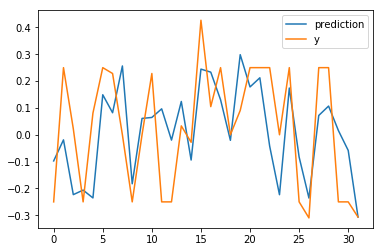

In [15]:
plt.plot([i for i in range(0,batch_size)], prediction, label='prediction')
plt.plot([i for i in range(0,batch_size)], y, label="y")
plt.legend()

y

(array([  1.90000000e+01,   1.23000000e+02,   1.57100000e+03,
          2.05030000e+04,   4.68760000e+04,   4.59970000e+04,
          1.88710000e+04,   1.34500000e+03,   7.40000000e+01,
          1.30000000e+01]),
 array([-1.41896533, -1.13345838, -0.84795144, -0.56244449, -0.27693755,
         0.0085694 ,  0.29407634,  0.57958328,  0.86509023,  1.15059717,
         1.43610412]),
 <a list of 10 Patch objects>)

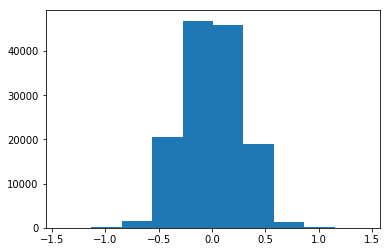

In [16]:
plt.hist(traning_set)

[[ 0.20453678]
 [ 0.09092458]
 [-0.19684368]]
(64, 64, 1)
(64, 64, 1)
(64, 64, 1)


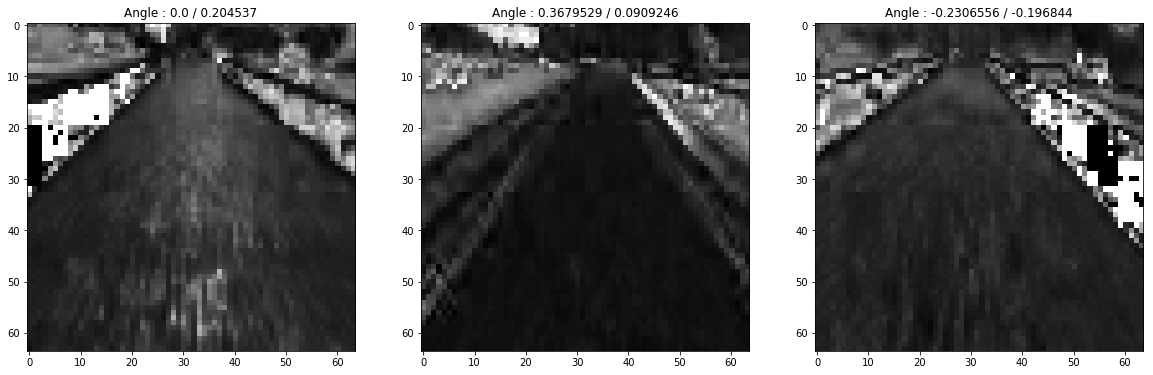

In [17]:
data = pd.read_csv("./data/driving_log.csv")


center_data = data[data.steering == 0].iloc[0]
left_data   = data[data.steering > 0.1].iloc[0]
right_data  = data[data.steering < -0.1].iloc[0]

center = preprocess(plt.imread("./data/" + center_data['center']))
left   = preprocess(plt.imread("./data/" + left_data['center'])) 
right  = preprocess(plt.imread("./data/" + right_data['center']))

images = [center,left,right]
angles = [center_data['steering'], left_data['steering'], right_data['steering']]

p = model.predict(np.array(images))
print(p)

plt.figure(1,figsize=(20,20))
for idx, image in enumerate(images):
    print(image.shape)
    plt.subplot(1,3,idx+1)
    plt.title('Angle : ' + str(angles[idx]) + " / " + str(p[idx][0]))
    plt.imshow(image[:,:,0], cmap='gray')
plt.show()

In [23]:
from numpy import newaxis
def preprocessImage(image):
    shape = image.shape
    # note: numpy arrays are (row, col)!
    image = image[math.floor(shape[0]/5):shape[0]-25, 0:shape[1]]
    image = cv2.resize(image,(64,64),  interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    image = image[:,:,2]
    image = image[..., newaxis]
    image = image/255.-.5
    return image

In [24]:
PATH = './data1'

df = pd.read_csv(PATH+'/driving_log.csv')

X = []
y = []


plt.figure()
plt.rcParams['figure.figsize'] = (12, 6)
for idx in range(0,10):
    filename = PATH+"/IMG/"+ df.iloc[idx]['center'].split("/")[-1]
    image    = plt.imread(filename)
    plt.subplot(2,5,idx+1)
    plt.title('Angle : ' +  str(df.iloc[idx]['steering']))
    plt.imshow(image)
    X.append(preprocess(image))
    y.append(df.iloc[idx]['steering'])
plt.show()

X = np.array(X)
y = np.array(y)

p = model.predict(X)
print(p)

plt.figure(figsize=(15,15))
for idx in range(0,10):
    plt.subplot(2,5,idx+1)
    plt.title('Angle : ' +  str(df.iloc[idx]['steering']) + "/" + str(p[idx]))
    plt.imshow(X[idx][:,:,0], cmap='gray')
plt.show()

KeyError: 'center'

In [23]:
x = data[data.steering < 0]
path  = x.iloc[0]['center']
angle = x.iloc[0]['steering']
print(path, angle)
#data.columns



IMG/center_2016_12_01_13_32_46_185.jpg -0.0787459


In [24]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def show_activations(activations_map,plt_num=1):
    activations  = activations_map[0] # We should have only one sample
    nbactivations = activations.shape[2]
    plt.figure(plt_num,figsize=(15,15))
    for idx in range(nactivations):
        plt.subplot(8,6, idx+1)
        plt.axis('off')
        plt.imshow(activations[:,:,idx], interpolation='None', cmap='jet')

        

In [25]:
from read_activations import *

In [41]:
activations = get_activations(model, np.array([center]), print_shape_only=True)
#print(activations[13])
#show_activations(activations[2])
#plt.suptitle('Convolution Layer 1')
#show_activations(activations[3],2)
#plt.suptitle('Convolution Layer 2')
#show_activations(activations[4],3)
#plt.suptitle('Convolution Layer 3')

display_activations(activations)

NameError: name 'get_activations' is not defined

In [42]:
idx = np.random.permutation(data.count()[0])
data.iloc[idx]

len(idx)

8036

32


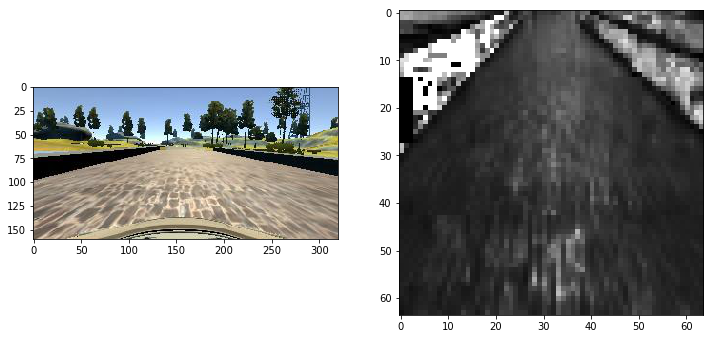

In [58]:
def preprocess(image):
    shape = image.shape
    print(math.floor(shape[0]/5))
    image = image[65:shape[0]-25, 0:shape[1]]
    image = cv2.resize(image,(64,64),  interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    image = image[:,:,2] 
    image = image[..., newaxis]
    return image

image, angle = random_camera(data,0)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image[:,:,:])
image = preprocess(image)
plt.subplot(1,2,2)
plt.imshow(image[:,:,0], cmap='gray')
